In [70]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import json
import os

## Import Pixels Data

In [71]:
# Import pixels data
pixels_filename = './dataset/pixels/Pixels backup_ 2022-02-07 18_28_02.258.json'
with open(pixels_filename, 'r') as file:
    pixels_objects = json.loads(file.read())

# Change extreme values closer to neutral and shift values by -1
def parse_pixel_obj(object):
    value = object['entries'][0]['value']
    if value == 1:
        value = 2
    elif value == 5:
        value = 4
    return {
        'date': object['date'],
        'mood': value-1
    }

parsed_pixel_objs = [ parse_pixel_obj(object) for object in pixels_objects ]

pixels_mood_df = pd.DataFrame(parsed_pixel_objs)
pixels_mood_df

,date,mood
0,2020-01-24,3
1,2020-01-25,3
2,2020-01-26,3
3,2020-01-27,3
4,2020-01-28,2
...,...,...
740,2022-02-02,3
741,2022-02-03,3
742,2022-02-04,3
743,2022-02-05,2


## Import Fitbit Data

In [72]:
# Import fitbit data

## Sleep
sleep_dir = './dataset/fitbit/Sleep'
sleep_json_files = list(filter(lambda filename: filename.startswith('sleep-'), os.listdir(sleep_dir)))

def load_sleep_json(filename):
    with open(os.path.join(sleep_dir, filename), 'r') as file:
        file_sleep_objs = json.loads(file.read())

    return file_sleep_objs

sleep_objects = []
for file in sleep_json_files:
    sleep_objects += load_sleep_json(file)


# Filter sleeps
sleep_obj_filter_lambda = lambda obj: obj['mainSleep'] and obj['levels'] and obj['type'] != 'classic'
sleep_objects = list(filter(sleep_obj_filter_lambda, sleep_objects))

def parse_sleep_object(obj):
    return {
        'date': obj['dateOfSleep'],
        'wake_minutes': obj['levels']['summary']['wake']['minutes'],
        'light_minutes': obj['levels']['summary']['light']['minutes'],
        'rem_minutes': obj['levels']['summary']['rem']['minutes'],
        'deep_minutes': obj['levels']['summary']['deep']['minutes'],
    }

parsed_sleep_objects = [ parse_sleep_object(obj) for obj in sleep_objects ]
sleep_df = pd.DataFrame(parsed_sleep_objects)

sleep_df

,date,wake_minutes,light_minutes,rem_minutes,deep_minutes
0,2018-03-03,55,245,80,132
1,2018-03-02,57,192,68,68
2,2018-03-01,47,195,58,91
3,2018-02-28,57,257,22,85
4,2018-02-27,41,174,54,64
...,...,...,...,...,...
1158,2022-02-06,67,261,83,113
1159,2022-02-05,45,215,75,93
1160,2022-02-04,82,255,53,125
1161,2022-02-03,68,245,85,100


In [73]:
## Resting heart rate

physical_activity_dir = './dataset/fitbit/Physical Activity'
hr_files = list(filter(lambda filename: filename.startswith('resting_heart_rate'), os.listdir(physical_activity_dir)))

hr_objects = []

for filename in hr_files:
    with open(os.path.join(physical_activity_dir, filename), 'r') as file:
        hr_objects += json.loads(file.read())

# Filter null heartrate objects
hr_objects = list(filter(lambda obj: obj['value']['date'], hr_objects))

def parse_hr_obj(obj):
    us_date = obj['value']['date']
    date = f"20{us_date[-2:]}-{us_date[:2]}-{us_date[3:5]}"
    return {
        'date': date,
        'resting_heartrate': obj['value']['value']
    }

parsed_hr_objects = [ parse_hr_obj(obj) for obj in hr_objects ]
hr_df = pd.DataFrame(parsed_hr_objects)
hr_df

,date,resting_heartrate
0,2018-02-24,64.000000
1,2018-02-25,63.392424
2,2018-02-26,60.323800
3,2018-02-27,61.019566
4,2018-02-28,61.809670
...,...,...
1144,2022-02-03,60.820997
1145,2022-02-04,59.765384
1146,2022-02-05,58.289222
1147,2022-02-06,58.807329


## Preprocess Data

In [74]:
# Merge dataframes on date
mood_hr_df = pd.merge(pixels_mood_df, hr_df, on="date", how="inner")
whole_df = pd.merge(mood_hr_df, sleep_df, on="date", how="inner")
whole_df

,date,mood,resting_heartrate,wake_minutes,light_minutes,rem_minutes,deep_minutes
0,2020-01-24,3,62.092401,65,290,66,49
1,2020-01-25,3,61.894955,76,287,57,103
2,2020-01-26,3,62.947462,64,294,40,74
3,2020-01-27,3,63.737734,43,260,60,57
4,2020-01-29,2,63.114227,50,224,36,71
...,...,...,...,...,...,...,...
760,2022-02-02,3,60.718213,91,307,59,116
761,2022-02-03,3,60.820997,68,245,85,100
762,2022-02-04,3,59.765384,82,255,53,125
763,2022-02-05,2,58.289222,45,215,75,93


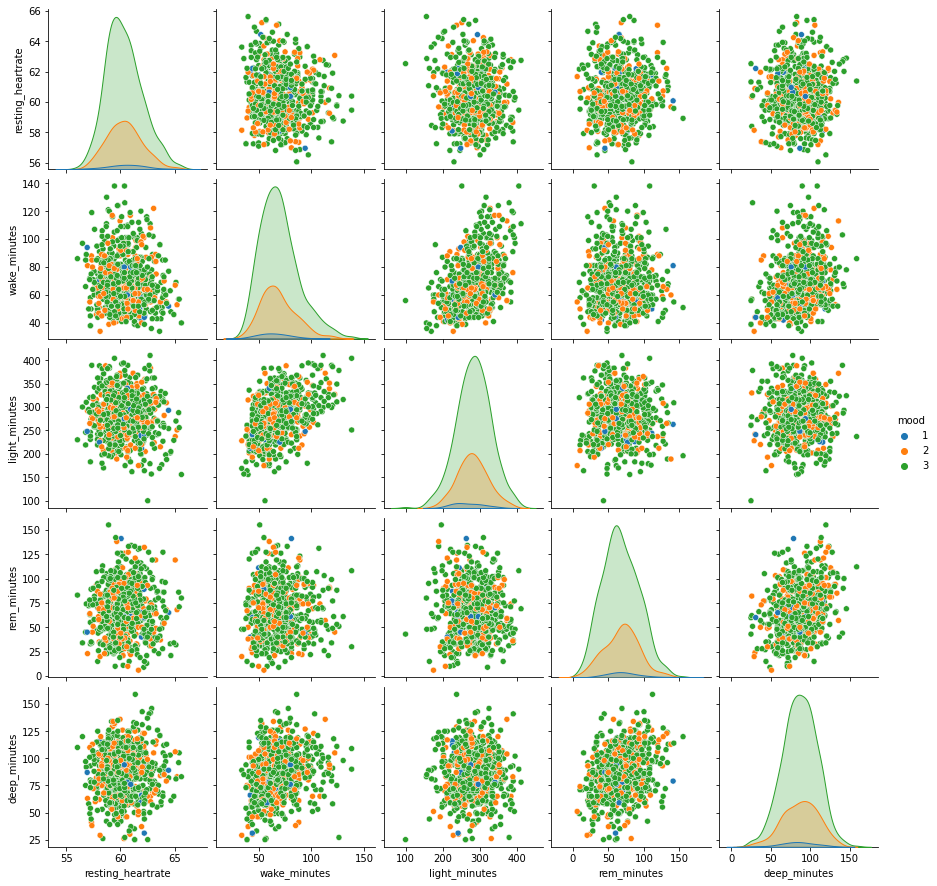

In [78]:
# Plot the data
sns.pairplot(whole_df,hue = 'mood',diag_kind = "kde", kind = "scatter", palette = "tab10")
plt.show()